In [46]:
# Imports -do not import any other libraries other than these
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

# You may add any other functions to make your code more modular. However,
# do not change the function signatures (name and arguments) of the given functions,
# as these functions will be called by the autograder.


class GaussianDiscriminantAnalysis:
    # Assume Binary Classification
    def __init__(self):
        self.mu_0 = None
        self.mu_1 = None
        self.sigma = None
        self.sigma_0 = None
        self.sigma_1 = None
        self.phi = None  # Class prior
        
    def normalize(self, X, use_stored_params=False):
        """
        Normalize the dataset X to have zero mean and unit variance.
        If use_stored_params is True, use the stored training mean and std.
        """
        return (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    
    def fit(self, X, y, assume_same_covariance=False):
        """
        Fit the Gaussian Discriminant Analysis model to the data.
        Remember to normalize the input data X before fitting the model.
        
        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The input data.
            
        y : numpy array of shape (n_samples,)
            The target labels - 0 or 1.
        
        learning_rate : float
            The learning rate to use in the update rule.
        
        Returns
        -------
        Parameters: 
            If assume_same_covariance = True - 3-tuple of numpy arrays mu_0, mu_1, sigma 
            If assume_same_covariance = False - 4-tuple of numpy arrays mu_0, mu_1, sigma_0, sigma_1
            The parameters learned by the model.
        """
        
        # Normalize input data
        X = self.normalize(X)
        
        # Compute class priors
        self.phi = np.mean(y)
        
        # Compute class-wise means
        self.mu_0 = np.mean(X[y == 0], axis=0)
        self.mu_1 = np.mean(X[y == 1], axis=0)
        
        # Compute class-wise covariance matrices
        if assume_same_covariance:
            n_0 = np.sum(y == 0)
            n_1 = np.sum(y == 1)
            sigma_0 = np.cov(X[y == 0].T, bias=True)
            sigma_1 = np.cov(X[y == 1].T, bias=True)
            self.sigma = (n_0 * sigma_0 + n_1 * sigma_1) / (n_0 + n_1)
            return self.mu_0, self.mu_1, self.sigma
        else:
            self.sigma_0 = np.cov(X[y == 0].T, bias=True)
            self.sigma_1 = np.cov(X[y == 1].T, bias=True)
            return self.mu_0, self.mu_1, self.sigma_0, self.sigma_1
    
    def predict(self, X):
        """
        Predict the target values for the input data.
        
        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The input data.
            
        Returns
        -------
        y_pred : numpy array of shape (n_samples,)
            The predicted target label.
        """
        X = self.normalize(X)  # Normalize input data
        
        if self.sigma is not None:
            # If shared covariance is used
            inv_sigma = np.linalg.inv(self.sigma)
            term_0 = -0.5 * np.sum((X - self.mu_0) @ inv_sigma * (X - self.mu_0), axis=1)
            term_1 = -0.5 * np.sum((X - self.mu_1) @ inv_sigma * (X - self.mu_1), axis=1)
        else:
            # If separate covariance matrices are used
            term_0 = multivariate_normal.logpdf(X, mean=self.mu_0, cov=self.sigma_0)
            term_1 = multivariate_normal.logpdf(X, mean=self.mu_1, cov=self.sigma_1)
        # Compute log posterior probability
        log_posterior_0 = term_0 + np.log(1 - self.phi)
        log_posterior_1 = term_1 + np.log(self.phi)
        
        # Predict class based on higher posterior probability
        return (log_posterior_1 > log_posterior_0).astype(int)


In [47]:
# Load data
X = np.loadtxt("../data/Q4/q4x.dat")
y = np.loadtxt("../data/Q4/q4y.dat", dtype=str)

# Convert target labels to numerical values (Alaska -> 0, Canada -> 1)
y = np.where(y == "Alaska", 0, 1)


In [55]:
# Instantiate and train model
gda_linear = GaussianDiscriminantAnalysis()
params_linear = gda_linear.fit(X, y, assume_same_covariance=True)

# Print results
print("phi:", gda_linear.phi)
print("mu_0:", gda_linear.mu_0.T)
print("mu_1:", gda_linear.mu_1.T)
print("sigma:", gda_linear.sigma)

phi: 0.5
mu_0: [-0.75529433  0.68509431]
mu_1: [ 0.75529433 -0.68509431]
sigma: [[ 0.42953048 -0.02247228]
 [-0.02247228  0.53064579]]


In [56]:
gda_quad = GaussianDiscriminantAnalysis()
params_quad = gda_quad.fit(X, y, assume_same_covariance=False)

# Print results
print("phi:", gda_quad.phi)
print("mu_0:", gda_quad.mu_0.T)
print("mu_1:", gda_quad.mu_1.T)
print("sigma_0:", gda_quad.sigma_0)
print("sigma_1:", gda_quad.sigma_1)

phi: 0.5
mu_0: [-0.75529433  0.68509431]
mu_1: [ 0.75529433 -0.68509431]
sigma_0: [[ 0.38158978 -0.15486516]
 [-0.15486516  0.64773717]]
sigma_1: [[0.47747117 0.1099206 ]
 [0.1099206  0.41355441]]


In [10]:
import matplotlib.pyplot as plt

In [60]:

# Normalize data for plotting
X = gda_linear.normalize(X)

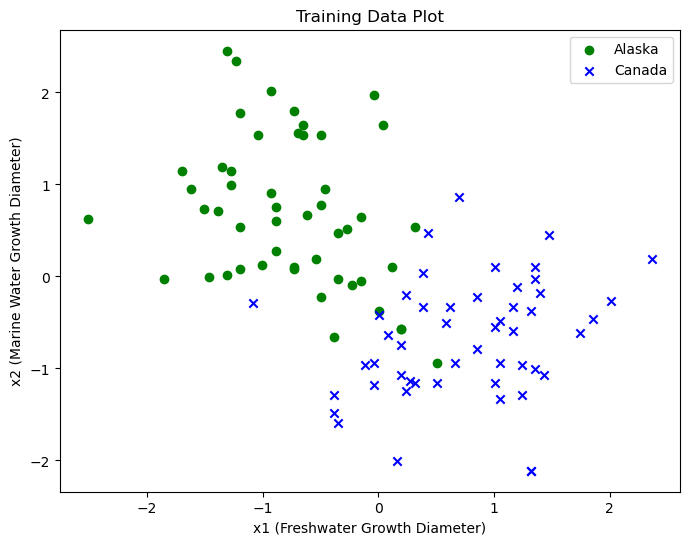

In [61]:
# Plot training data

plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='o', label='Alaska', color='green')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='x', label='Canada', color='blue')
plt.xlabel("x1 (Freshwater Growth Diameter)")
plt.ylabel("x2 (Marine Water Growth Diameter)")
plt.title("Training Data Plot")
plt.legend()
plt.show()

/tmp/ipykernel_48532/3314183911.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, Z_linear, levels=[0.5], colors='black', linestyles='-', label='Linear Boundary')
/tmp/ipykernel_48532/3314183911.py:22: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, Z_quad, levels=[0.5], colors='red', linestyles='-', label='Quadratic Boundary')


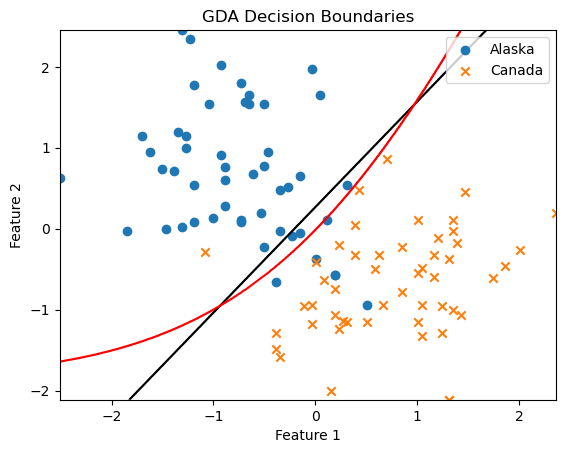

In [62]:
# Plot training data along with decision boundaries

# Plot the training data
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='o', label='Alaska')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='x', label='Canada')

# Plot decision boundaries
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
x_vals = np.linspace(x_min, x_max, 1000)
y_vals = np.linspace(y_min, y_max, 1000)
X_grid, Y_grid = np.meshgrid(x_vals, y_vals)

# Linear decision boundary (shared covariance)
Z_linear = gda_linear.predict(np.c_[X_grid.ravel(), Y_grid.ravel()])
Z_linear = Z_linear.reshape(X_grid.shape)
plt.contour(X_grid, Y_grid, Z_linear, levels=[0.5], colors='black', linestyles='-', label='Linear Boundary')

# Quadratic decision boundary (separate covariances)
Z_quad = gda_quad.predict(np.c_[X_grid.ravel(), Y_grid.ravel()])
Z_quad = Z_quad.reshape(X_grid.shape)
plt.contour(X_grid, Y_grid, Z_quad, levels=[0.5], colors='red', linestyles='-', label='Quadratic Boundary')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("GDA Decision Boundaries")
plt.show()

